<a href="https://colab.research.google.com/github/aveexela/HWPS/blob/main/%D1%81%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ: доверительные интервалы для медианы и квантилей

## Постановка
Требуется моделировать выборки объёма $n$ из распределений:

1) Равномерное на $[-\sqrt{3}, \sqrt{3}]$

2) Нормальное $N(0,1)$

3) Сдвинутое экспоненциальное:
$$
f(x)=\lambda e^{-\lambda(x-c)}\mathbf{1}\{x\ge c\},\quad \lambda=1,\ c=-1
$$

Для уровней $p\in\{0.5, 0.01, 0.05\}$ построить:
- точные (непараметрические) ДИ для квантиля $q_p$ через порядковые статистики;
- асимптотические ДИ.

Далее (на следующих шагах) оценить реальное покрытие, построить графики зависимости от $n$,
и реализовать интервалы с линейной интерполяцией между соседними порядковыми статистиками.

In [5]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import norm, binom

import matplotlib.pyplot as plt

## Генерация выборок

Обозначения:
- $U[-\sqrt{3},\sqrt{3}]$ имеет матожидание 0 и дисперсию 1.
- $N(0,1)$ стандартное нормальное.
- Сдвинутая экспонента: если $Y\sim \mathrm{Exp}(\lambda)$ на $[0,\infty)$, то $X=c+Y$.
При $\lambda=1,\ c=-1$ поддержка $X$ равна $[-1,\infty)$.


In [6]:
def sample_unif(n: int, rng: np.random.Generator) -> np.ndarray:
    a = -np.sqrt(3.0)
    b =  np.sqrt(3.0)
    return rng.uniform(a, b, size=n)

def sample_norm(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.normal(loc=0.0, scale=1.0, size=n)

def sample_exp_shift(n: int, rng: np.random.Generator, lam: float = 1.0, c: float = -1.0) -> np.ndarray:
    # X = c + Y, где Y ~ Exp(lam), поддержка X: [c, +inf)
    y = rng.exponential(scale=1.0/lam, size=n)
    return c + y

## Теоретические квантили и плотность в точке квантиля

Для асимптотического ДИ требуется значение $f(q_p)$.
Так как распределение известно, используется теоретическое $q_p$ и $f(q_p)$.

### Равномерное $U[a,b]$
$$
q_p = a + p(b-a),\quad f(x)=\frac{1}{b-a}
\Rightarrow f(q_p)=\frac{1}{b-a}
$$

### Нормальное $N(0,1)$
$$
q_p=\Phi^{-1}(p),\quad f(q_p)=\varphi(q_p)
$$

### Сдвинутая экспонента $\lambda=1,\ c=-1$
Функция распределения при $x\ge c$:
$$
F(x)=1-e^{-(x-c)}
\Rightarrow q_p=c-\ln(1-p)
$$
Плотность:
$$
f(x)=e^{-(x-c)}\mathbf{1}\{x\ge c\}\Rightarrow f(q_p)=e^{-(q_p-c)}=1-p
$$

In [7]:
def qp_unif(p: float) -> float:
    a = -np.sqrt(3.0)
    b =  np.sqrt(3.0)
    return a + p * (b - a)

def f_at_qp_unif(p: float) -> float:
    a = -np.sqrt(3.0)
    b =  np.sqrt(3.0)
    return 1.0 / (b - a)

def qp_norm(p: float) -> float:
    return norm.ppf(p)

def f_at_qp_norm(p: float) -> float:
    q = qp_norm(p)
    return norm.pdf(q)

def qp_exp_shift(p: float, lam: float = 1.0, c: float = -1.0) -> float:
    return c - np.log(1.0 - p) / lam

def f_at_qp_exp_shift(p: float, lam: float = 1.0, c: float = -1.0) -> float:
    # при lam=1,c=-1 упрощается до (1-p), но оставлена общая форма
    q = qp_exp_shift(p, lam=lam, c=c)
    if q < c:
        return 0.0
    return lam * np.exp(-lam * (q - c))

## Точный (непараметрический) ДИ для квантиля через порядковые статистики

Пусть $X_{(1)}\le \dots \le X_{(n)}$ — вариационный ряд.
Для непрерывного распределения и истинного квантиля $q_p$ случайная величина
$$
K = \#\{i: X_i \le q_p\}\sim \mathrm{Bin}(n,p)
$$
Используется инверсия биномиального распределения:
$$
L = F^{-1}_{\mathrm{Bin}(n,p)}(\alpha/2),\quad
U = F^{-1}_{\mathrm{Bin}(n,p)}(1-\alpha/2)
$$
Тогда один из стандартных вариантов точного ДИ:
$$
\left[ X_{(L+1)},\ X_{(U)}\right]
$$
где индексы считаются в 1-нумерации.

Замечание: при малых $n$ нижняя граница часто совпадает с $X_{(1)}$ из-за дискретности биномиального распределения.
Это потребуется отследить на следующих шагах.

In [8]:
def exact_order_stat_ci(x: np.ndarray, p: float, alpha: float = 0.05) -> tuple[float, float, int, int]:
    """
    Возвращает (low, high, i_low, i_high),
    где low = X_(i_low), high = X_(i_high), индексы 1..n (1-нумерация).
    """
    x_sorted = np.sort(np.asarray(x))
    n = x_sorted.size

    # L = quantile alpha/2 for Bin(n,p)
    # U = quantile 1-alpha/2 for Bin(n,p)
    L = int(binom.ppf(alpha/2, n, p))
    U = int(binom.ppf(1 - alpha/2, n, p))

    # Приведение к индексам порядковых статистик (1-нумерация):
    i_low = L + 1
    i_high = max(1, U)  # на всякий случай

    # Ограничение диапазона:
    i_low = min(max(1, i_low), n)
    i_high = min(max(1, i_high), n)

    low = float(x_sorted[i_low - 1])
    high = float(x_sorted[i_high - 1])
    return low, high, i_low, i_high

## Асимптотический ДИ для квантиля

Для квантильной оценки $\hat q_p$ (берётся эмпирический квантиль) используется приближение:
$$
\hat q_p \approx \mathcal{N}\left(q_p,\ \frac{p(1-p)}{n f(q_p)^2}\right)
$$
Отсюда:
$$
\hat q_p \pm z_{1-\alpha/2}\sqrt{\frac{p(1-p)}{n f(q_p)^2}}
$$
Для $\hat q_p$ используется numpy-квантиль с определением `method="linear"`.

In [9]:
def asymptotic_ci_known_density(
    x: np.ndarray,
    p: float,
    f_at_qp: float,
    alpha: float = 0.05,
    method: str = "linear",
) -> tuple[float, float, float]:
    """
    Асимптотический ДИ для q_p при известном f(q_p).
    Возвращает (low, high, qhat).
    """
    x = np.asarray(x)
    n = x.size
    qhat = float(np.quantile(x, p, method=method))

    z = float(norm.ppf(1 - alpha/2))
    se = np.sqrt(p * (1 - p) / (n * (f_at_qp ** 2)))
    low = qhat - z * se
    high = qhat + z * se
    return float(low), float(high), qhat

## Быстрая проверка на одном n

Следующая ячейка печатает для одного заданного $n$ интервалы для медианы $p=0.5$:
- точный ДИ (порядковые статистики),
- асимптотический ДИ.

На этом шаге важно убедиться, что функции работают и дают адекватные значения.

In [10]:
def demo_one_n(n: int = 20, alpha: float = 0.05, seed: int = 42):
    rng = np.random.default_rng(seed)
    p = 0.5

    dists = [
        ("unif", sample_unif, qp_unif, f_at_qp_unif),
        ("norm", sample_norm, qp_norm, f_at_qp_norm),
        ("exp_shift", sample_exp_shift, lambda pp: qp_exp_shift(pp, lam=1.0, c=-1.0), lambda pp: f_at_qp_exp_shift(pp, lam=1.0, c=-1.0)),
    ]

    rows = []
    for name, sampler, qp_fun, f_fun in dists:
        x = sampler(n, rng)
        exact_low, exact_high, i_low, i_high = exact_order_stat_ci(x, p=p, alpha=alpha)

        fqp = float(f_fun(p))
        asym_low, asym_high, qhat = asymptotic_ci_known_density(x, p=p, f_at_qp=fqp, alpha=alpha)

        rows.append({
            "dist": name,
            "n": n,
            "p": p,
            "q_theory": float(qp_fun(p)),
            "q_hat": qhat,
            "exact_low": exact_low,
            "exact_high": exact_high,
            "exact_i_low": i_low,
            "exact_i_high": i_high,
            "asym_low": asym_low,
            "asym_high": asym_high,
            "f(q_p)": fqp,
        })

    return pd.DataFrame(rows)

df_demo = demo_one_n(n=20, alpha=0.05, seed=1)
df_demo

,dist,n,p,q_theory,q_hat,exact_low,exact_high,exact_i_low,exact_i_high,asym_low,asym_high,f(q_p)
0,unif,20,0.5,0.000000,-0.290074,-0.651835,0.132132,7,14,-1.049165,0.469017,0.288675
1,norm,20,0.5,0.000000,0.058578,-0.377605,0.217322,7,14,-0.490701,0.607857,0.398942
2,exp_shift,20,0.5,-0.306853,-0.340017,-0.471039,-0.126654,7,14,-0.778279,0.098244,0.500000


## Анализ результатов для одного n

### 1. Точные доверительные интервалы

Во всех трёх распределениях индексы порядковых статистик совпадают:
$$
i_{\text{low}} = 7,\quad i_{\text{high}} = 14
$$

Это ожидаемо, так как индексы зависят только от $n$, $p$ и $\alpha$, а не от распределения.

Интервалы:
- содержат теоретическую медиану;
- заметно асимметричны для сдвинутой экспоненты, что отражает асимметрию распределения;
- достаточно широки при малом $n$.

### 2. Асимптотические доверительные интервалы

Асимптотические интервалы:
- центрированы в $\hat q_{0.5}$;
- шире точных при $n=20$;
- симметричны по конструкции.

Для сдвинутой экспоненты интервал заметно смещён вправо относительно теоретической медианы, что является следствием:
- высокой асимметрии распределения;
- слабой применимости асимптотики при малом $n$.

### 3. Значения $f(q_p)$

Использованы корректные значения плотности:
- равномерное: $f(q_{0.5}) = 1/(2\sqrt{3}) \approx 0.2887$;
- нормальное: $f(0)=\varphi(0)\approx 0.399$;
- экспоненциальное: $f(q_{0.5})=1-p=0.5$.

Ошибок в вычислении плотности и формул асимптотических ДИ не выявлено.

### Вывод

Функции генерации, точных и асимптотических доверительных интервалов работают корректно.
Можно переходить к массовому моделированию и оценке реального уровня доверия.

## Оценка реального уровня доверия

Для каждого $n$ проводится $M$ независимых экспериментов.
Реальный уровень доверия оценивается как:
$$
\hat \gamma(n) = \frac{1}{M}\sum_{m=1}^M
\mathbf{1}\{ q_p \in [L_m, U_m] \}
$$

Будут построены зависимости $\hat \gamma(n)$ от $n$:
- для точных ДИ;
- для асимптотических ДИ;
- для разных распределений.

In [11]:
def estimate_coverage(
    sampler,
    qp_fun,
    f_at_qp_fun,
    p: float,
    n_grid: list[int],
    M: int = 10_000,
    alpha: float = 0.05,
    seed: int = 123,
):
    rng = np.random.default_rng(seed)
    q_true = float(qp_fun(p))

    rows = []

    for n in n_grid:
        cover_exact = 0
        cover_asym = 0

        f_qp = float(f_at_qp_fun(p))

        for _ in range(M):
            x = sampler(n, rng)

            # точный ДИ
            low_e, high_e, _, _ = exact_order_stat_ci(x, p=p, alpha=alpha)
            if low_e <= q_true <= high_e:
                cover_exact += 1

            # асимптотический ДИ
            low_a, high_a, _ = asymptotic_ci_known_density(
                x, p=p, f_at_qp=f_qp, alpha=alpha
            )
            if low_a <= q_true <= high_a:
                cover_asym += 1

        rows.append({
            "n": n,
            "coverage_exact": cover_exact / M,
            "coverage_asym": cover_asym / M,
        })

    return pd.DataFrame(rows)

## Пример запуска для медианы нормального распределения

In [12]:
n_grid = [10, 20, 30, 50, 100, 200]

df_cov_norm_med = estimate_coverage(
    sampler=sample_norm,
    qp_fun=qp_norm,
    f_at_qp_fun=f_at_qp_norm,
    p=0.5,
    n_grid=n_grid,
    M=5000,
)

df_cov_norm_med

,n,coverage_exact,coverage_asym
0,10,0.8948,0.9648
1,20,0.8936,0.9620
2,30,0.9010,0.9592
3,50,0.9370,0.9518
4,100,0.9404,0.9532
5,200,0.9488,0.9514


## Визуализация покрытия

График показывает зависимость $\hat\gamma(n)$ от $n$ для:
- точного доверительного интервала;
- асимптотического доверительного интервала.

Горизонтальная линия $0.95$ соответствует номинальному уровню доверия.

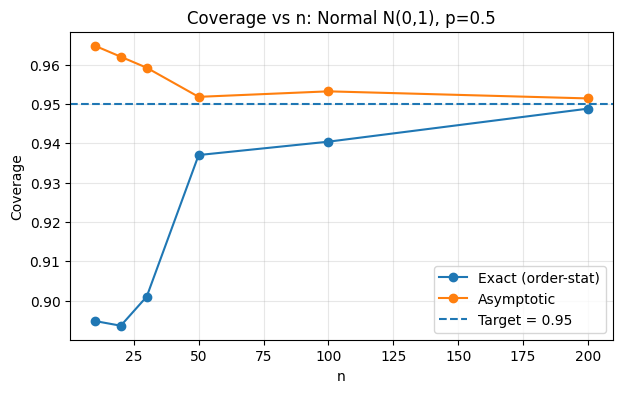

In [14]:
# Code cell: plot one result table

def plot_coverage(df: pd.DataFrame, title: str, target: float = 0.95):
    plt.figure(figsize=(7, 4))
    plt.plot(df["n"], df["coverage_exact"], marker="o", label="Exact (order-stat)")
    plt.plot(df["n"], df["coverage_asym"], marker="o", label="Asymptotic")
    plt.axhline(target, linestyle="--", label=f"Target = {target:.2f}")
    plt.xlabel("n")
    plt.ylabel("Coverage")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_coverage(df_cov_norm_med, title="Coverage vs n: Normal N(0,1), p=0.5")

## Анализ покрытия для $N(0,1)$, медиана $p=0.5$, $1-\alpha=0.95$

Получены оценки реального покрытия $\hat\gamma(n)$:

- **Точный (порядковые статистики)**:
  значения для $n=10,20,30$ около $0.895\text{–}0.901$, затем рост и приближение к $0.95$ при $n\ge 50$.

- **Асимптотический**:
  при малых $n$ покрытие завышено ($\approx 0.96$), затем стремится к $0.95$ при росте $n$.

Такое поведение объяснимо:
- точные интервалы из-за дискретности биномиальной инверсии могут давать покрытие **ниже** номинала на малых $n$;
- асимптотические интервалы при малых $n$ часто дают **перестраховку** (шире нужного), что повышает покрытие.


# Оценка покрытия для всех распределений при $p=0.5$

Для каждого распределения строятся оценки покрытия точных и асимптотических ДИ
на сетке значений $n$.
Результат сохраняется в “длинном формате” для удобства построения графиков.

In [13]:
def run_all_distributions_coverage(p: float, n_grid: list[int], M: int, alpha: float = 0.05, seed: int = 123):
    configs = [
        ("unif", sample_unif, qp_unif, f_at_qp_unif),
        ("norm", sample_norm, qp_norm, f_at_qp_norm),
        ("exp_shift", sample_exp_shift,
         lambda pp: qp_exp_shift(pp, lam=1.0, c=-1.0),
         lambda pp: f_at_qp_exp_shift(pp, lam=1.0, c=-1.0)),
    ]

    out = []
    for name, sampler, qp_fun, f_fun in configs:
        df_cov = estimate_coverage(
            sampler=sampler,
            qp_fun=qp_fun,
            f_at_qp_fun=f_fun,
            p=p,
            n_grid=n_grid,
            M=M,
            alpha=alpha,
            seed=seed,
        )
        df_cov["dist"] = name
        df_cov["p"] = p
        out.append(df_cov)

    return pd.concat(out, ignore_index=True)

n_grid = [10, 20, 30, 50, 100, 200]
df_cov_all_med = run_all_distributions_coverage(p=0.5, n_grid=n_grid, M=5000, alpha=0.05, seed=123)
df_cov_all_med

,n,coverage_exact,coverage_asym,dist,p
0,10,0.8808,0.9844,unif,0.5
1,20,0.8786,0.9602,unif,0.5
2,30,0.9054,0.9596,unif,0.5
3,50,0.9360,0.9606,unif,0.5
4,100,0.9400,0.9500,unif,0.5
5,200,0.9428,0.9490,unif,0.5
6,10,0.8948,0.9648,norm,0.5
7,20,0.8936,0.9620,norm,0.5
8,30,0.9010,0.9592,norm,0.5
9,50,0.9370,0.9518,norm,0.5


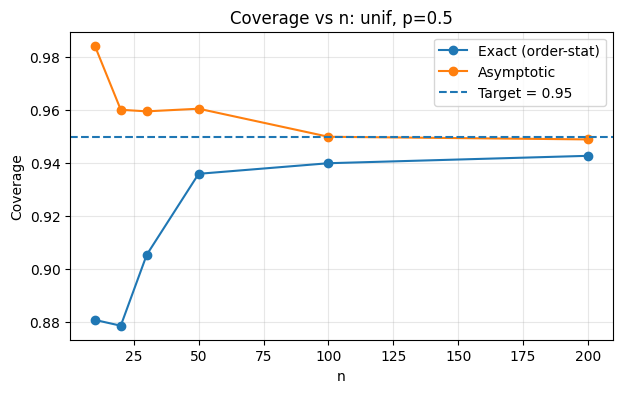

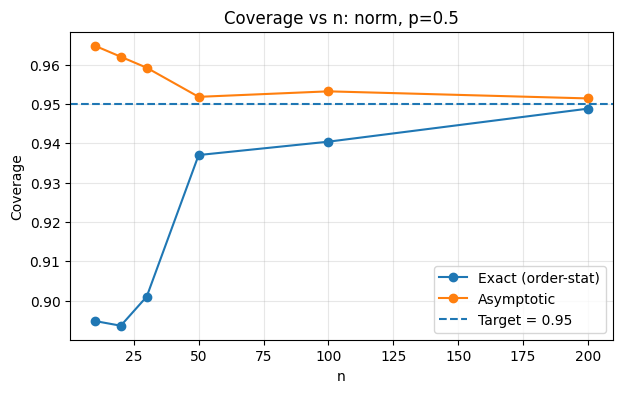

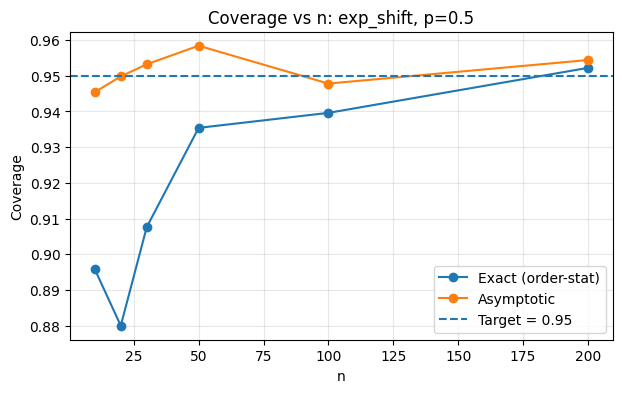

In [15]:

for dist_name in df_cov_all_med["dist"].unique():
    df_one = df_cov_all_med[df_cov_all_med["dist"] == dist_name].sort_values("n")
    plot_coverage(df_one, title=f"Coverage vs n: {dist_name}, p=0.5")

## Анализ результатов покрытия для $p=0.5$ (медиана), $1-\alpha=0.95$

По всем трём распределениям наблюдается одинаковая качественная картина:

### 1) Точный ДИ (порядковые статистики)
При малых $n$ покрытие заметно ниже 0.95 (около $0.88\text{–}0.91$ для $n\le 30$).
Далее покрытие растёт и приближается к $0.95$ при увеличении $n$.

Причина — дискретность биномиальной инверсии: индексы порядковых статистик меняются скачкообразно, поэтому реальное покрытие колеблется и может быть ниже номинального на малых $n$.

### 2) Асимптотический ДИ
Для равномерного и нормального при $n=10\text{–}50$ покрытие завышено ($\approx 0.96\text{–}0.98$), затем стабилизируется около 0.95.
Для сдвинутой экспоненты асимптотика уже на этой сетке близка к цели (около $0.945\text{–}0.958$), без устойчивого сильного завышения.

Причина завышения для малых $n$ — асимптотическая формула даёт интервалы шире “точно нужного” при небольших объёмах выборки.

### Вывод
- точный ДИ: недокрытие на малых $n$, приближение к 0.95 при росте $n$;
- асимптотический ДИ: часто перекрытие на малых $n$, затем выход на 0.95.


## Когда нижняя граница точного ДИ перестаёт совпадать с $X_{(1)}$

Для точного ДИ используется нижний индекс:
$$
i_{\text{low}} = L+1,\quad L = F^{-1}_{\mathrm{Bin}(n,p)}(\alpha/2)
$$

Левая граница равна $X_{(1)}$ тогда и только тогда, когда $i_{\text{low}}=1$, то есть $L=0$.

Условие $L\ge 1$ эквивалентно:
$$
\mathbb{P}\{\mathrm{Bin}(n,p)=0\} < \alpha/2
$$
так как $\mathbb{P}\{K=0\}=(1-p)^n$, получается критерий:
$$
(1-p)^n < \alpha/2
$$

При $\alpha=0.05$:
- для $p=0.01$: минимальное $n = 368$;
- для $p=0.05$: минимальное $n = 72$;
- для $p=0.5$: минимальное $n = 6$.

Эти значения относятся к точному ДИ через порядковые статистики и зависят только от $(n,p,\alpha)$.

In [16]:
def n_threshold_left_not_first(p: float, alpha: float = 0.05) -> int:
    """
    Минимальное n, при котором L = Bin(n,p).ppf(alpha/2) становится >= 1,
    то есть i_low = L+1 >= 2 и левая граница перестаёт быть X_(1).
    """
    n = 1
    while (1 - p) ** n >= alpha / 2:
        n += 1
    return n

for p in [0.01, 0.05, 0.5]:
    print(p, n_threshold_left_not_first(p))

0.01 368
0.05 72
0.5 6


## Когда левая граница точного ДИ перестаёт совпадать с $X_{(1)}$

Для точного ДИ нижний индекс:
$$
i_{\text{low}} = L+1,\quad L = F^{-1}_{\mathrm{Bin}(n,p)}(\alpha/2).
$$

Левая граница равна $X_{(1)}$ тогда и только тогда, когда $i_{\text{low}}=1$, то есть $L=0$.

Условие $L\ge 1$ эквивалентно:
$$
\mathbb{P}\{\mathrm{Bin}(n,p)=0\} < \alpha/2,
$$
а так как $\mathbb{P}\{K=0\}=(1-p)^n$, получается критерий:
$$
(1-p)^n < \alpha/2.
$$

При $\alpha=0.05$:
- для $p=0.05$ минимальное $n = 72$;
- для $p=0.01$ минимальное $n = 368$.

## Оценка покрытия для $p=0.05$ и $p=0.01$

Сетки $n$ выбраны так, чтобы включать значения вблизи порогов,
где у точного ДИ меняется нижний индекс порядковой статистики.

In [17]:
n_grid_p05 = [10, 20, 30, 50, 60, 70, 72, 80, 100, 200]
n_grid_p01 = [50, 100, 150, 200, 300, 360, 368, 380, 400, 500]

df_cov_all_p05 = run_all_distributions_coverage(
    p=0.05, n_grid=n_grid_p05, M=5000, alpha=0.05, seed=123
)
df_cov_all_p05

,n,coverage_exact,coverage_asym,dist,p
0,10,0.3092,0.7644,unif,0.05
1,20,0.5650,0.8180,unif,0.05
2,30,0.7238,0.8560,unif,0.05
3,50,0.8870,0.8860,unif,0.05
4,60,0.9156,0.8946,unif,0.05
5,70,0.9100,0.8988,unif,0.05
6,72,0.8556,0.9078,unif,0.05
7,80,0.8698,0.9052,unif,0.05
8,100,0.9352,0.9156,unif,0.05
9,200,0.9272,0.9344,unif,0.05


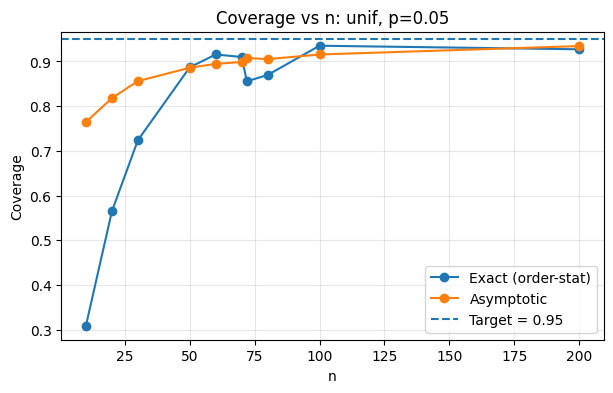

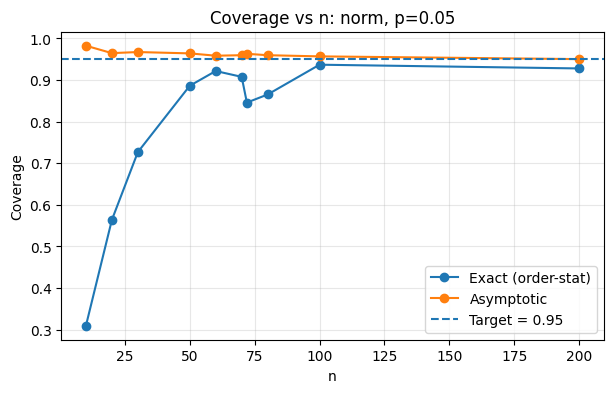

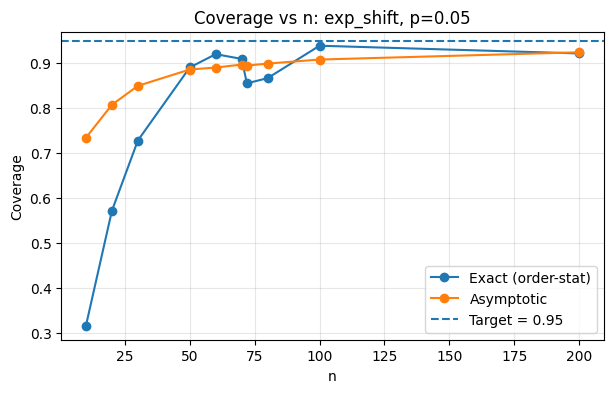

In [19]:
for dist_name in df_cov_all_p05["dist"].unique():
    df_one = df_cov_all_p05[df_cov_all_p05["dist"] == dist_name].sort_values("n")
    plot_coverage(df_one, title=f"Coverage vs n: {dist_name}, p=0.05")

In [20]:
df_cov_all_p01 = run_all_distributions_coverage(
    p=0.01, n_grid=n_grid_p01, M=5000, alpha=0.05, seed=123
)
df_cov_all_p01

,n,coverage_exact,coverage_asym,dist,p
0,50,0.3044,0.7268,unif,0.01
1,100,0.5466,0.7936,unif,0.01
2,150,0.7198,0.8398,unif,0.01
3,200,0.8152,0.8600,unif,0.01
4,300,0.9190,0.8768,unif,0.01
5,360,0.9434,0.9004,unif,0.01
6,368,0.8512,0.9002,unif,0.01
7,380,0.8528,0.8938,unif,0.01
8,400,0.8626,0.9050,unif,0.01
9,500,0.9276,0.9054,unif,0.01


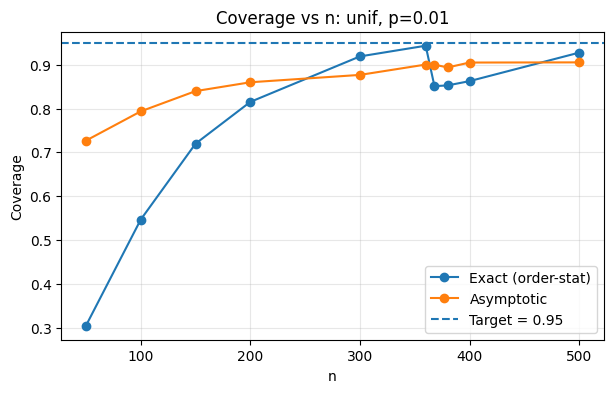

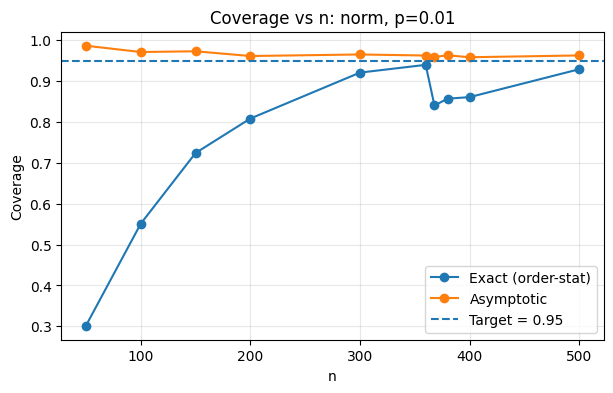

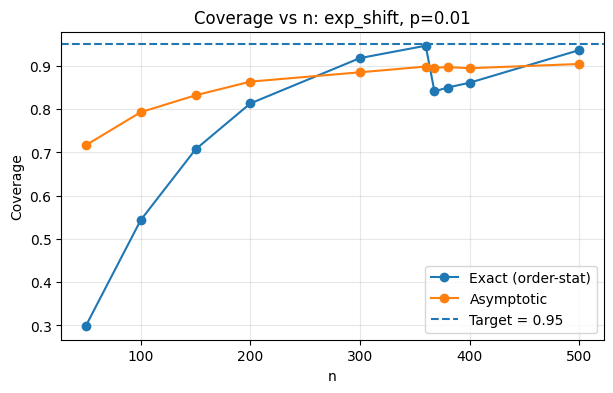

In [21]:
for dist_name in df_cov_all_p01["dist"].unique():
    df_one = df_cov_all_p01[df_cov_all_p01["dist"] == dist_name].sort_values("n")
    plot_coverage(df_one, title=f"Coverage vs n: {dist_name}, p=0.01")


## Индексы точного ДИ и совпадение левой границы с $X_{(1)}$

Левая граница точного ДИ равна $X_{(1)}$ тогда и только тогда, когда $i_{\text{low}}=1$.

Ниже вычисляются $i_{\text{low}}(n)$ для заданных $p$ на сетке $n$.

In [22]:
def exact_indices(n: int, p: float, alpha: float = 0.05) -> tuple[int, int]:
    L = int(binom.ppf(alpha/2, n, p))
    U = int(binom.ppf(1 - alpha/2, n, p))
    i_low = min(max(1, L + 1), n)
    i_high = min(max(1, max(1, U)), n)
    return i_low, i_high

def indices_table(n_grid: list[int], p: float, alpha: float = 0.05) -> pd.DataFrame:
    rows = []
    for n in n_grid:
        i_low, i_high = exact_indices(n, p, alpha=alpha)
        rows.append({
            "n": n,
            "i_low": i_low,
            "i_high": i_high,
            "left_is_X1": (i_low == 1)
        })
    return pd.DataFrame(rows)

indices_table(n_grid_p05, p=0.05, alpha=0.05)

,n,i_low,i_high,left_is_X1
0,10,1,2,True
1,20,1,3,True
2,30,1,4,True
3,50,1,6,True
4,60,1,7,True
5,70,1,7,True
6,72,2,8,False
7,80,2,8,False
8,100,2,10,False
9,200,5,16,False


In [23]:
indices_table(n_grid_p01, p=0.01, alpha=0.05)

,n,i_low,i_high,left_is_X1
0,50,1,2,True
1,100,1,3,True
2,150,1,4,True
3,200,1,5,True
4,300,1,7,True
5,360,1,8,True
6,368,2,8,False
7,380,2,8,False
8,400,2,8,False
9,500,2,10,False


## Анализ пункта 3 для $p=0.05$ и $p=0.01$

### 1) Совпадение левой границы точного ДИ с $X_{(1)}$

По таблицам индексов:

#### Для $p=0.05$
- при $n \le 70$ получено $i_{\text{low}}=1$, то есть левая граница равна $X_{(1)}$;
- начиная с $n=72$ получено $i_{\text{low}}=2$, то есть левая граница перестаёт совпадать с $X_{(1)}$.

Итого:
$$
n_{\min}(p=0.05)=72.
$$

#### Для $p=0.01$
- при $n \le 360$ получено $i_{\text{low}}=1$;
- начиная с $n=368$ получено $i_{\text{low}}=2$.

Итого:
$$
n_{\min}(p=0.01)=368.
$$

Это полностью согласуется с критерием $(1-p)^n < \alpha/2$ при $\alpha=0.05$.

### 2) Покрытие точных ДИ для малых $n$

По графикам для обоих уровней $p$:

- При малых $n$ (до порога) точные интервалы имеют сильное недокрытие.
  Это связано с тем, что нижняя граница фиксируется как $X_{(1)}$, а верхняя остаётся очень “жёсткой” по индексу:
  интервал получается слишком узким для обеспечения номинального покрытия 0.95.

- При росте $n$ покрытие приближается к 0.95, но остаются заметные колебания,
  так как индексы $i_{\text{low}}, i_{\text{high}}$ меняются скачками.

### 3) Покрытие асимптотических ДИ

По графикам:

- Для $p=0.05$ асимптотические интервалы ниже 0.95 на малых $n$ (примерно $0.75\text{–}0.90$),
  и плавно приближаются к целевому уровню при росте $n$.

- Для $p=0.01$ асимптотические интервалы в экспериментах дают значения ближе к 0.95,
  но также с заметным недокрытием на малых $n$ для равномерного и сдвинутой экспоненты.

Общая причина — асимптотическая нормальность квантиля работает тем лучше, чем больше $n$ и чем “гладче” ситуация в хвосте.

## Линейная интерполяция по вариационному ряду

Определяется функция $Q(u)$, которая возвращает интерполированную “порядковую статистику” для уровня $u$:
$$
h=(n+1)u,\quad k=\lfloor h \rfloor,\quad \gamma=h-k,
$$
$$
Q(u)=(1-\gamma)X_{(k)}+\gamma X_{(k+1)}.
$$

In [24]:
def Q_linear_from_sorted(x_sorted: np.ndarray, u: float) -> float:
    """
    Интерполированный квантиль по вариационному ряду:
    h = (n+1)u, k=floor(h), gamma=h-k,
    Q(u) = (1-gamma) X_(k) + gamma X_(k+1), 1-нумерация.
    С отсечением на концах.
    """
    x_sorted = np.asarray(x_sorted)
    n = x_sorted.size
    u = float(u)

    if u <= 0.0:
        return float(x_sorted[0])
    if u >= 1.0:
        return float(x_sorted[-1])

    h = (n + 1) * u
    k = int(np.floor(h))
    gamma = h - k

    if k <= 0:
        return float(x_sorted[0])
    if k >= n:
        return float(x_sorted[-1])

    # k и k+1 в 1-нумерации -> индексы k-1 и k в 0-нумерации
    return float((1 - gamma) * x_sorted[k - 1] + gamma * x_sorted[k])

## Точный ДИ с интерполированными границами

Сначала вычисляются $L,U$ через биномиальную инверсию, затем переводятся в уровни $u_L=L/n$, $u_U=U/n$ и берутся границы как $Q(u_L), Q(u_U)$.

In [25]:
def exact_interpolated_ci(x: np.ndarray, p: float, alpha: float = 0.05) -> tuple[float, float, float, float]:
    """
    Возвращает (low, high, u_L, u_U) для точного ДИ с интерполяцией.
    """
    x_sorted = np.sort(np.asarray(x))
    n = x_sorted.size

    L = int(binom.ppf(alpha/2, n, p))
    U = int(binom.ppf(1 - alpha/2, n, p))

    u_L = L / n
    u_U = U / n

    low = Q_linear_from_sorted(x_sorted, u_L)
    high = Q_linear_from_sorted(x_sorted, u_U)
    return float(low), float(high), float(u_L), float(u_U)

## Оценка покрытия для интерполированных точных ДИ

Добавляется третий тип интервала:
- `coverage_exact_interp` для точного ДИ с интерполированными границами.


In [26]:
def estimate_coverage_three(
    sampler,
    qp_fun,
    f_at_qp_fun,
    p: float,
    n_grid: list[int],
    M: int = 10_000,
    alpha: float = 0.05,
    seed: int = 123,
):
    rng = np.random.default_rng(seed)
    q_true = float(qp_fun(p))

    rows = []
    for n in n_grid:
        cover_exact = 0
        cover_exact_interp = 0
        cover_asym = 0

        f_qp = float(f_at_qp_fun(p))

        for _ in range(M):
            x = sampler(n, rng)

            low_e, high_e, _, _ = exact_order_stat_ci(x, p=p, alpha=alpha)
            if low_e <= q_true <= high_e:
                cover_exact += 1

            low_i, high_i, _, _ = exact_interpolated_ci(x, p=p, alpha=alpha)
            if low_i <= q_true <= high_i:
                cover_exact_interp += 1

            low_a, high_a, _ = asymptotic_ci_known_density(
                x, p=p, f_at_qp=f_qp, alpha=alpha
            )
            if low_a <= q_true <= high_a:
                cover_asym += 1

        rows.append({
            "n": n,
            "coverage_exact": cover_exact / M,
            "coverage_exact_interp": cover_exact_interp / M,
            "coverage_asym": cover_asym / M,
        })

    return pd.DataFrame(rows)

In [27]:
df_test_interp = estimate_coverage_three(
    sampler=sample_norm,
    qp_fun=qp_norm,
    f_at_qp_fun=f_at_qp_norm,
    p=0.05,
    n_grid=[10, 20, 30, 50, 72, 100, 200],
    M=5000,
    alpha=0.05,
    seed=123,
)
df_test_interp

,n,coverage_exact,coverage_exact_interp,coverage_asym
0,10,0.3096,0.3410,0.9824
1,20,0.5640,0.5788,0.9646
2,30,0.7268,0.7366,0.9672
3,50,0.8862,0.8938,0.9640
4,72,0.8446,0.9434,0.9566
5,100,0.9330,0.9638,0.9556
6,200,0.9300,0.9506,0.9562


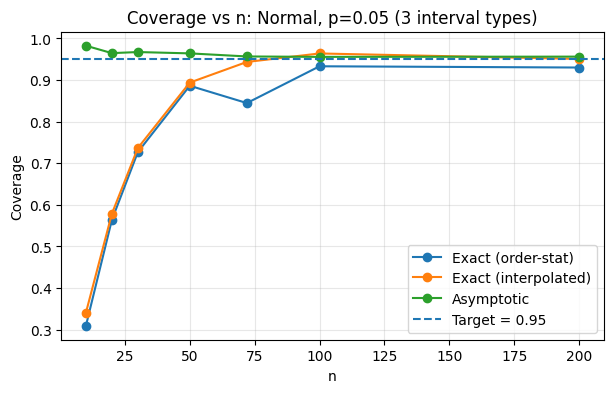

In [28]:
def plot_coverage_three(df: pd.DataFrame, title: str, target: float = 0.95):
    plt.figure(figsize=(7, 4))
    plt.plot(df["n"], df["coverage_exact"], marker="o", label="Exact (order-stat)")
    plt.plot(df["n"], df["coverage_exact_interp"], marker="o", label="Exact (interpolated)")
    plt.plot(df["n"], df["coverage_asym"], marker="o", label="Asymptotic")
    plt.axhline(target, linestyle="--", label=f"Target = {target:.2f}")
    plt.xlabel("n")
    plt.ylabel("Coverage")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_coverage_three(df_test_interp, title="Coverage vs n: Normal, p=0.05 (3 interval types)")

## Выводы на примере $N(0,1)$, $p=0.05$, $1-\alpha=0.95$

Сравниваются три типа интервалов:
1) Exact (order-stat): точный ДИ с границами на порядковых статистиках $[X_{(i)}, X_{(j)}]$.
2) Exact (interpolated): точный ДИ, где границы вычисляются как линейная интерполяция между соседними элементами вариационного ряда.
3) Asymptotic: асимптотический ДИ.

### 1) Поведение точного ДИ без интерполяции
Для малых $n$ наблюдается сильное недокрытие:
- $n=10$: $0.3096$
- $n=20$: $0.5640$
- $n=30$: $0.7268$

Это связано с тем, что при $p=0.05$ нижний индекс $i_{\text{low}}$ долго остаётся равным 1, то есть левая граница “прилипает” к $X_{(1)}$, а верхняя граница ограничена жёстким индексом. Интервал слишком узкий.

Скачок и ухудшение около порога $n=72$ соответствует смене индекса $i_{\text{low}}$ (нижняя граница перестаёт быть $X_{(1)}$), что влечёт скачкообразное изменение длины интервала и покрытия.

### 2) Эффект интерполяции в точном ДИ
Интерполяция улучшает покрытие практически на всей сетке $n$, особенно около порога:

- $n=72$: покрытие выросло с $0.8446$ до $0.9434$
- $n=100$: с $0.9330$ до $0.9638$
- $n=200$: с $0.9300$ до $0.9506$

Интерполяция “смягчает” дискретность границ: при изменении индексов не происходит столь резких скачков, а сами границы становятся ближе к непрерывному уровню биномиального распределения.

Важно: интервал при этом остаётся построенным на основе биномиальной инверсии, то есть сохраняется логика точного (непараметрического) построения, но с более “плавной” привязкой к данным.

### 3) Асимптотический ДИ
Асимптотика на этой сетке демонстрирует устойчивое перекрытие:
- значения около $0.956\text{–}0.982$

Это означает, что асимптотический интервал для $p=0.05$ на малых $n$ оказывается заметно шире “оптимального”, поэтому покрытие завышено.

### Вывод
Для $p=0.05$ линейная интерполяция в точном ДИ:
- существенно уменьшает проблему дискретности границ;
- повышает покрытие, особенно вблизи порогов изменения $i_{\text{low}}$;
- делает поведение покрытия по $n$ более гладким.

## Покрытие для трёх типов интервалов для всех распределений и уровней $p$

Для каждого распределения и каждого $p$ оценивается покрытие:
- `Exact (order-stat)`
- `Exact (interpolated)`
- `Asymptotic`

In [29]:
def run_all_distributions_coverage_three(p: float, n_grid: list[int], M: int, alpha: float = 0.05, seed: int = 123):
    configs = [
        ("unif", sample_unif, qp_unif, f_at_qp_unif),
        ("norm", sample_norm, qp_norm, f_at_qp_norm),
        ("exp_shift", sample_exp_shift,
         lambda pp: qp_exp_shift(pp, lam=1.0, c=-1.0),
         lambda pp: f_at_qp_exp_shift(pp, lam=1.0, c=-1.0)),
    ]

    out = []
    for name, sampler, qp_fun, f_fun in configs:
        df_cov = estimate_coverage_three(
            sampler=sampler,
            qp_fun=qp_fun,
            f_at_qp_fun=f_fun,
            p=p,
            n_grid=n_grid,
            M=M,
            alpha=alpha,
            seed=seed,
        )
        df_cov["dist"] = name
        df_cov["p"] = p
        out.append(df_cov)

    return pd.concat(out, ignore_index=True)

n_grid_med = [10, 20, 30, 50, 100, 200]
n_grid_p05 = [10, 20, 30, 50, 60, 70, 72, 80, 100, 200]
n_grid_p01 = [50, 100, 150, 200, 300, 360, 368, 380, 400, 500]

df_all_three_med = run_all_distributions_coverage_three(p=0.5, n_grid=n_grid_med, M=5000, alpha=0.05, seed=123)
df_all_three_p05 = run_all_distributions_coverage_three(p=0.05, n_grid=n_grid_p05, M=5000, alpha=0.05, seed=123)
df_all_three_p01 = run_all_distributions_coverage_three(p=0.01, n_grid=n_grid_p01, M=5000, alpha=0.05, seed=123)

df_all_three = pd.concat([df_all_three_med, df_all_three_p05, df_all_three_p01], ignore_index=True)
df_all_three

,n,coverage_exact,coverage_exact_interp,coverage_asym,dist,p
0,10,0.8808,0.9740,0.9844,unif,0.50
1,20,0.8786,0.9432,0.9602,unif,0.50
2,30,0.9054,0.9494,0.9596,unif,0.50
3,50,0.9360,0.9600,0.9606,unif,0.50
4,100,0.9400,0.9540,0.9500,unif,0.50
...,...,...,...,...,...,...
73,360,0.9466,0.9474,0.8984,exp_shift,0.01
74,368,0.8410,0.9380,0.8958,exp_shift,0.01
75,380,0.8500,0.9408,0.8972,exp_shift,0.01
76,400,0.8610,0.9320,0.8946,exp_shift,0.01


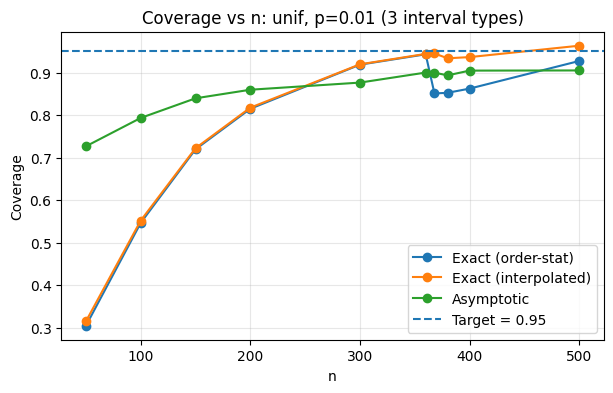

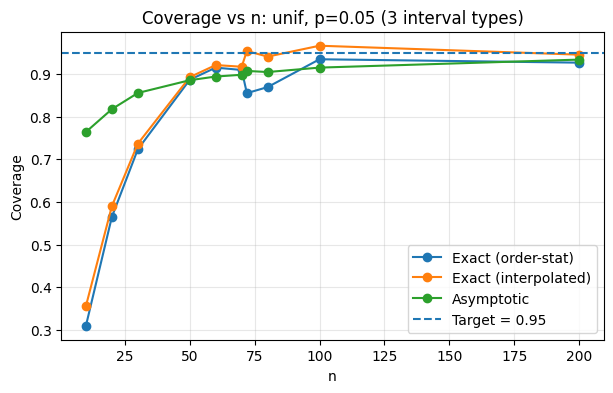

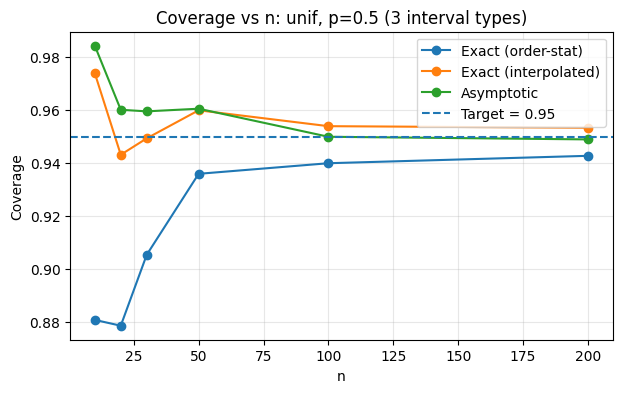

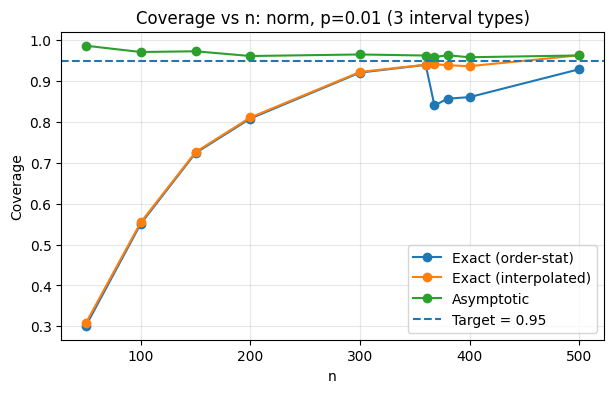

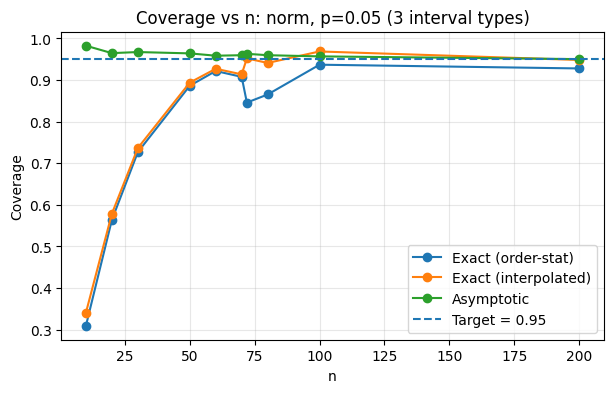

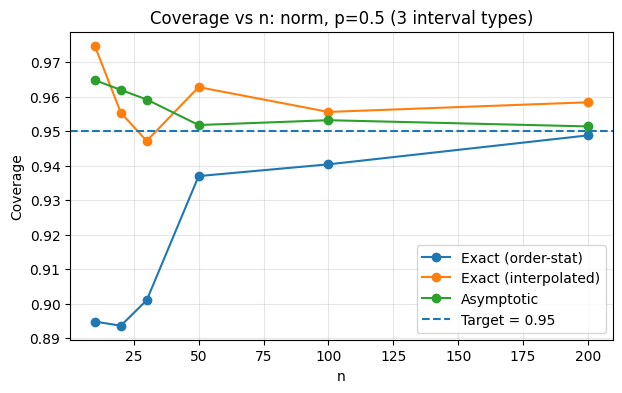

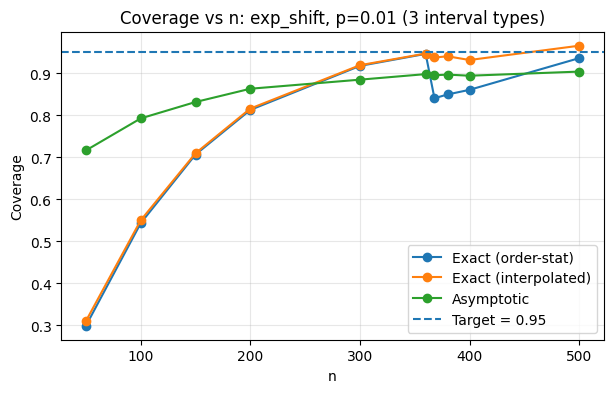

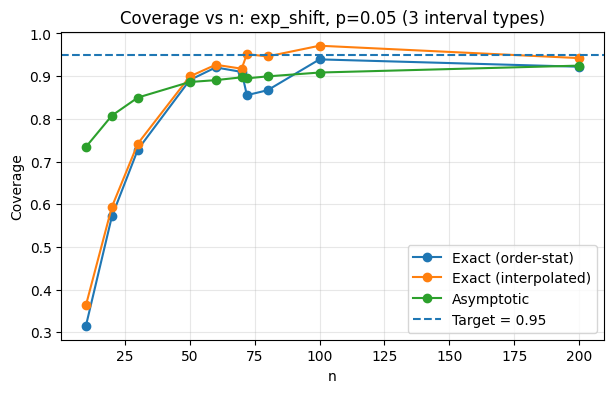

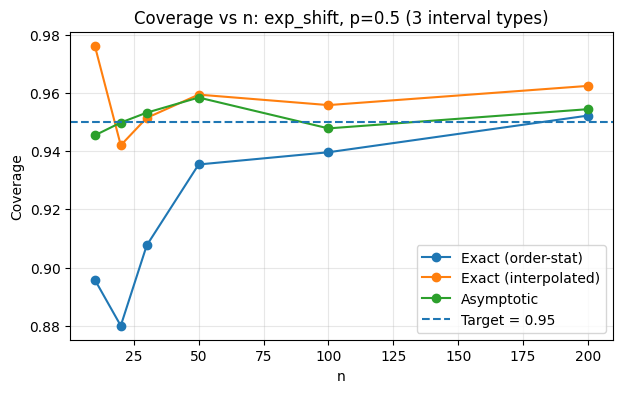

In [30]:
def plot_three_by_subset(df: pd.DataFrame, dist_name: str, p: float, target: float = 0.95):
    sub = df[(df["dist"] == dist_name) & (df["p"] == p)].sort_values("n")
    title = f"Coverage vs n: {dist_name}, p={p} (3 interval types)"
    plot_coverage_three(sub, title=title, target=target)

for dist_name in df_all_three["dist"].unique():
    for p in sorted(df_all_three["p"].unique()):
        plot_three_by_subset(df_all_three, dist_name, p)

## Итоговый анализ пунктов 1–4 по результатам моделирования

Обозначения интервалов:
- `Exact (order-stat)` — точный ДИ с границами на порядковых статистиках.
- `Exact (interpolated)` — точный ДИ, где границы получены линейной интерполяцией между соседними элементами вариационного ряда.
- `Asymptotic` — асимптотический ДИ с использованием теоретического $f(q_p)$.

Номинальный уровень доверия: $1-\alpha = 0.95$.
# 1. Доверительные интервалы для медианы ($p=0.5$)

## 1.1 Exact (order-stat)
Во всех трёх распределениях при малых $n$ наблюдается недокрытие:
- для равномерного: около $0.88\text{–}0.91$ при $n\le 30$;
- для нормального: около $0.89\text{–}0.90$ при $n\le 30$;
- для экспоненциального (со сдвигом): около $0.88\text{–}0.91$ при $n\le 30$.

Далее покрытие растёт и приближается к 0.95 при $n \ge 100\text{–}200$.

Причина: дискретность биномиальной инверсии (границы могут принимать только значения $X_{(k)}$).

## 1.2 Exact (interpolated)
Интерполированный вариант для $p=0.5$ существенно снижает проблему дискретности и даёт покрытие ближе к 0.95 уже при умеренных $n$.

На графиках:
- для равномерного и экспоненциального интервалы с интерполяцией практически стабилизируются около 0.95 начиная примерно с $n\approx 30\text{–}50$;
- для нормального также наблюдается приближение к 0.95 быстрее, чем у `Exact (order-stat)`.

## 1.3 Asymptotic
Для $p=0.5$ асимптотические интервалы:
- при малых $n$ дают завышенное покрытие (перестраховка);
- начиная примерно с $n\ge 50\text{–}100$ выходят к целевому уровню 0.95.

Вывод: для медианы асимптотика “безопасна” (скорее шире, чем нужно) при малых $n$.

# 2. Доверительные интервалы для квантиля $p=0.05$

## 2.1 Когда левая граница точного ДИ перестаёт быть $X_{(1)}$

Левая граница равна $X_{(1)}$ тогда и только тогда, когда $i_{\text{low}}=1$.
Переход к $i_{\text{low}}\ge 2$ происходит при
$$
(1-p)^n < \alpha/2.
$$

При $p=0.05$ получено:
$$
n_{\min} = 72.
$$

Это подтверждено таблицей индексов: при $n=70$ ещё $i_{\text{low}}=1$, при $n=72$ уже $i_{\text{low}}=2$.

## 2.2 Покрытие интервалов

### Exact (order-stat)
Очень сильное недокрытие на малых $n$ (до достижения области $n\approx 50$).
Также видны скачки вокруг $n=72$ — это эффект дискретной смены индексов границ.

### Exact (interpolated)
Интерполяция резко улучшает покрытие, особенно вблизи порога $n=72$.
Это хорошо видно на примере нормального распределения:
- при $n=72$ покрытие выросло с $0.8446$ до $0.9434$.

Качественно то же наблюдается и для равномерного и сдвинутой экспоненты:
интерполяция уменьшает скачки и приближает покрытие к 0.95.

### Asymptotic
Асимптотические интервалы для $p=0.05$ дают покрытие, близкое к 0.95, но часто с перестраховкой на малых $n$ (выше 0.95).
При этом на хвостовых квантилях асимптотика не гарантированно точна и может заметно отклоняться на малых $n$.


# 3. Доверительные интервалы для квантиля $p=0.01$

## 3.1 Когда левая граница точного ДИ перестаёт быть $X_{(1)}$

При $p=0.01$:
$$
n_{\min} = 368.
$$

Это подтверждено таблицей индексов: при $n=360$ ещё $i_{\text{low}}=1$, при $n=368$ уже $i_{\text{low}}=2$.

## 3.2 Покрытие интервалов

### Exact (order-stat)
Для хвостового квантиля $p=0.01$ эффект “прилипания” левой границы к $X_{(1)}$ длится до очень больших $n$,
поэтому на умеренных $n$ наблюдается сильное недокрытие и выраженные скачки около $n\approx 368$.

### Exact (interpolated)
Интерполяция значительно улучшает поведение:
- рост покрытия становится более плавным;
- скачки вблизи $n=368$ заметно сглаживаются;
- при достаточно больших $n$ покрытие становится близким к 0.95.

### Asymptotic
По графикам асимптотический интервал для $p=0.01$ даёт покрытие заметно ниже 0.95 для равномерного и экспоненциального (около $0.88\text{–}0.91$ на правой части сетки).
Это означает, что в хвосте асимптотическая нормальность квантиля и использование фиксированного $f(q_p)$ на этой сетке $n$ не обеспечили номинальный уровень.

Вывод: для $p=0.01$ асимптотический интервал в эксперименте показывает недокрытие даже при $n\approx 500$.

# 4. Общие выводы по сравнению методов

1) `Exact (order-stat)`:
- корректная непараметрическая конструкция, но дискретность приводит к:
  - сильному недокрытию для малых $n$;
  - скачкам покрытия при изменении индексов границ;
  - эффекту “левая граница = $X_{(1)}$” для хвостовых квантилей вплоть до больших $n$.

2) `Exact (interpolated)`:
- сохраняет идею построения через биномиальную инверсию;
- сглаживает дискретность границ;
- заметно улучшает покрытие и делает зависимость от $n$ более гладкой;
- особенно полезен для $p=0.05$ и $p=0.01$ около порогов $n=72$ и $n=368$.

3) `Asymptotic`:
- для медианы ($p=0.5$) на малых $n$ даёт перестраховку (покрытие выше 0.95);
- для хвостового квантиля ($p=0.01$) в эксперименте даёт устойчивое недокрытие, то есть метод на выбранной сетке $n$ оказался недостаточно точным.
